## Modules:

In [ ]:
!pip install torchinfo
!pip install torchsampler
!pip install noisereduce

In [2]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import librosa
import sys
from datetime import datetime
from tqdm import tqdm
import numpy as np
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pathlib
import random
import IPython.display as ipd
import noisereduce as nr
import pickle
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import torchvision
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchsampler import ImbalancedDatasetSampler
import torchvision.models as models
import torch.multiprocessing as mp
import multiprocessing
import cv2
from torch import Tensor
from pytz import timezone

## GPU/CPU:

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

Using device cuda


## Helper:

In [4]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec.cpu(), origin='lower', aspect=aspect)   #librosa.power_to_db(spec.cpu()), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [5]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

## Config/Constants:

In [6]:
# Dataset:
#ANNOTATIONS_FILE = "/kaggle/input/msc-dataset/MSC_metadata.csv"
ANNOTATIONS_FILE = "/kaggle/input/msc-dataset/PilotFabrik_metadata.csv"
AUDIO_DIR = "/kaggle/input/msc-dataset/audio_4sec/audio_4sec"
NOISE_DIR = "/kaggle/input/msc-dataset/noise/noise"
SAMPLE_RATE = 44100
AUDIO_LENGTH = 4
NUM_SAMPLES = AUDIO_LENGTH*SAMPLE_RATE

# Dataloader:
BATCH_SIZE = 32
NUM_WORKERS = 0

# Optimizer:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01

# Training:
EPOCHS = 50

# Transformations:
N_FFT=1024
WIN_LENGTH=1024
HOP_LENGTH=512
N_MELS=64 #64 #128

## Dataset:

In [ ]:
# analyse balance of dataset
msc_df = pd.read_csv(ANNOTATIONS_FILE)
msc_df_train = msc_df[msc_df.split=='train']
msc_df_val = msc_df[msc_df.split=='val']
msc_df

In [9]:
def label_mapping(annotations_file):
    df = pd.read_csv(annotations_file)
    labels = sorted(df['label'].unique())
    F = {}
    key2label_map = {}
    label2key_map = {}
    for key, label in enumerate(labels):
        label2key_map[label] = key
        key2label_map[key] = label
    return label2key_map, key2label_map

label2key_map, key2label_map = label_mapping(ANNOTATIONS_FILE)

num_labels = len(label2key_map)
print('Labels: ',list(key2label_map.values()))

Labels:  ['Bench_grinder', 'Cordless_screwdriver', 'Drill_press', 'Filing', 'Grab_screws', 'Hammer', 'Sanding']


In [10]:
US8k = False
if US8k:
    us8k_labels = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']
    key2label_map = dict(zip(range(len(us8k_labels)), us8k_labels))
    num_labels = len(key2label_map)

In [11]:
class MSC_Dataset(Dataset):
    def __init__(self, 
                 annotations_file, 
                 audio_dir, 
                 split,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device, 
                 label2key_map):
        self.split = split
        self.annotations = pd.read_csv(annotations_file)[pd.read_csv(annotations_file)['split']==self.split]
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation#.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.label2key_map = label2key_map
        
    def __len__(self):
        return len(self.annotations)
        
    def __getitem__(self, index):
        audio_sample_path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0]+r'.wav')
        label = self.annotations.iloc[index, 2] 
        label = self.label2key_map[label]
        signal, sr = torchaudio.load(audio_sample_path) # normalized within [-1.0, 1.0]
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal.to(device), torch.tensor(label).to(device)
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(device)
            signal = resampler(signal)
        return signal
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True).to(device)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def get_labels(self):
        return self.annotations['label']
    
    def get_audio(self, index):
        audio_sample_path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0]+r'.wav')
        signal, sr = torchaudio.load(audio_sample_path) 
        signal = signal#.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        #signal = background_noise(signal)
        return signal

In [12]:
class US8k_Dataset(Dataset):
    def __init__(self, 
                 annotations_file, 
                 audio_dir, 
                 split,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device, 
                 fold_id):
        meta = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation#.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        
        if split == 'train':
            self.meta = meta[meta.loc[:, 'fold'] != fold_id] 
        else:
            self.meta = meta[meta.loc[:, 'fold'] == fold_id]
        
    def __len__(self):
        return len(self.meta)
        
    def __getitem__(self, index):
        meta_i = self.meta.iloc[index]
        audio_sample_path = os.path.join(self.audio_dir, 'fold'+str(meta_i['fold']), meta_i['slice_file_name'])
        label = meta_i['classID']#.to(self.device)
        signal, sr = torchaudio.load(audio_sample_path) # normalized within [-1.0, 1.0]
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal.to(device), torch.tensor(label).to(device)
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def get_labels(self):
        return self.annotations['label']
    
    #def get_audio(self, index):
    #    audio_sample_path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0]+r'.wav')
    #    signal, sr = torchaudio.load(audio_sample_path) 
    #    signal = signal#.to(self.device)
    #    signal = self._resample_if_necessary(signal, sr)
    #    signal = self._mix_down_if_necessary(signal)
    #    signal = self._cut_if_necessary(signal)
    #    signal = self._right_pad_if_necessary(signal)
    #    #signal = background_noise(signal)
    #    return signal

## Transformations:

In [ ]:
spec_length = math.ceil(SAMPLE_RATE*AUDIO_LENGTH/HOP_LENGTH)

#--------------------------------------------------------------------------------------
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, 
                                                       n_fft=N_FFT, 
                                                       hop_length=HOP_LENGTH, 
                                                       n_mels=N_MELS
                                                       ).to(device)
#--------------------------------------------------------------------------------------
power_to_db = torchaudio.transforms.AmplitudeToDB().to(device)
#--------------------------------------------------------------------------------------
mfcc = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE, 
                                  n_mfcc=N_MELS,
                                  #melkwargs={
                                  #          "n_fft": int(N_FFT),
                                  #          "n_mels": N_MELS,
                                  #          "hop_length": int(HOP_LENGTH)}
                                  ).to(device)
#--------------------------------------------------------------------------------------
freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=N_MELS*0.2, #maximum possible length of the mask
                                                      iid_masks=True #whether to apply different masks to each example/channel in the batch
                                                     ).to(device) 
#--------------------------------------------------------------------------------------
time_masking = torchaudio.transforms.TimeMasking(time_mask_param=spec_length*0.2, #maximum possible length of the mask
                                                 iid_masks=True #whether to apply different masks to each example/channel in the batch
                                                ).to(device) 
#--------------------------------------------------------------------------------------
normalize = torchvision.transforms.Normalize(107.4691, 1247.5967).to(device) # mean and std from raw dataset, computed in previously on untransformed data

In [14]:
class Time_Stretch: #custom because of complex error
    def __init__(self, n_freq, up_low_rate):
        self.n_freq = n_freq
        self.up_low_rate = up_low_rate     
        
    def __call__(self, spec):
        rate = np.random.randint(int(self.up_low_rate[0]*10), int(self.up_low_rate[1]*10))/10
        stretch = torchaudio.transforms.TimeStretch(n_freq=self.n_freq, fixed_rate=rate).to(device)
        stretched = stretch(spec)
        return stretched.real
    
time_stretch= Time_Stretch(n_freq=N_MELS, up_low_rate=(0.8, 1.2))

In [15]:
class custom_spec(object):
    def __init__(self, sample_rate, required_shape):
        self.sample_rate = sample_rate
        self.required_shape = required_shape
        
    def __call__(self, signal):
        
        signal = signal.cpu().numpy()
        stft = np.abs(librosa.stft(signal.squeeze()))**2
        spec = librosa.feature.melspectrogram(S=stft, sr=self.sample_rate)
        spec_dB = librosa.power_to_db(spec, ref=np.max)
        down_spec = cv2.resize(spec_dB, dsize=self.required_shape, interpolation=cv2.INTER_LINEAR)
        return torch.from_numpy(down_spec)[None, :]
        
#custom_spec = custom_spec(sample_rate=22050, required_shape=(64,64))

In [16]:
class correct_size_if_necessary(object):
    """ Brings all tensors to same size.
        Applies random left and right cutting, if tensor is too long. 
        Applies radnom left and right padding, if tensor is too short.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        self.output_size = output_size
        
    def __call__(self, spec):
        if tuple(spec.shape)==self.output_size:
            return spec
        
        elif spec.shape[2] > self.output_size[2]: #cut randomly left and right
            over = spec.shape[2] - self.output_size[2]
            rand_start = np.random.randint(0, over) # randomly choose a start postion
            spec = spec[:,:,rand_start:(self.output_size[2]+rand_start)]
            return spec
        
        elif spec.shape[2] < self.output_size[2]: #pad randomly left and right
            missing = self.output_size[2] - spec.shape[2]
            rand_start = np.random.randint(0, missing) # randomly choose a start postion
            rand_padding = (rand_start, missing-rand_start) 
            spec = torch.nn.functional.pad(spec, rand_padding)
            return spec

resize = correct_size_if_necessary(output_size=(1, N_MELS, spec_length))

In [17]:
class RandomApply(torch.nn.Module):
    """Apply randomly a list of transformations with a given probability.
    .. note::
        In order to script the transformation, please use ``torch.nn.ModuleList`` as input instead of list/tuple of
        transforms as shown below:
        >>> transforms = transforms.RandomApply(torch.nn.ModuleList([
        >>>     transforms.ColorJitter(),
        >>> ]), p=0.3)
        >>> scripted_transforms = torch.jit.script(transforms)
        Make sure to use only scriptable transformations, i.e. that work with ``torch.Tensor``, does not require
        `lambda` functions or ``PIL.Image``.
    Args:
        transforms (list or tuple or torch.nn.Module): list of transformations
        p (float): probability
    """

    def __init__(self, transforms, p=0.8):
        super().__init__()
        self.transforms = transforms
        self.p = p

    def forward(self, img):
        if self.p < torch.rand(1):
            return img
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        format_string += "\n    p={}".format(self.p)
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_string

In [18]:
class ComposeMany(object):
    """
    Data augmentation module that transforms any given data example randomly
    resulting in N correlated views of the same example
    """

    def __init__(self, transforms, num_augmented_samples):
        self.transforms = transforms
        self.num_augmented_samples = num_augmented_samples

    def __call__(self, x):
        samples = []
        for _ in range(self.num_augmented_samples):
            samples.append(self.transform(x).unsqueeze(dim=0).clone())
        return torch.cat(samples, dim=0)
    
    def transform(self, x):
        for t in self.transforms:
            x = t(x)
        return x

In [19]:
class GaussNoise(torch.nn.Module):
    def __init__(self, min_snr=0.0001, max_snr=0.01):
        """
        Add Gaussian noise to raw audio signal.
        :param min_snr: Minimum signal-to-noise ratio
        :param max_snr: Maximum signal-to-noise ratio
        """
        super().__init__()
        self.min_snr = min_snr
        self.max_snr = max_snr

    def forward(self, audio):
        std = torch.std(audio)
        noise_std = random.uniform(self.min_snr * std, self.max_snr * std)

        noise = torch.empty(audio.shape).normal_(0.0, noise_std).to(device)

        return audio + noise
    
gaussnoise = GaussNoise(min_snr=0.001, max_snr=0.05)

In [20]:
class RandomResizedCrop(torch.nn.Module):
    '''
    Crops raw audio file randomly at the start and end to n_samples.
    '''
    def __init__(self, n_samples):
        super().__init__()
        self.n_samples = int(n_samples)

    def forward(self, audio):
        max_samples = audio.shape[-1]
        start_idx = random.randint(0, max_samples - self.n_samples)
        audio = audio[..., start_idx : start_idx + self.n_samples]
        return audio
    
rand_crop = RandomResizedCrop(0.9*AUDIO_LENGTH*SAMPLE_RATE)

In [21]:
class RandomBackgroundNoise:
    def __init__(self, sample_rate, noise_dir, min_snr_db=10, max_snr_db=25):
        self.sample_rate = sample_rate
        self.min_snr_db = min_snr_db
        self.max_snr_db = max_snr_db

        if not os.path.exists(noise_dir):
            raise IOError(f'Noise directory `{noise_dir}` does not exist')
        # find all WAV files including in sub-folders:
        self.noise_files_list = list(pathlib.Path(noise_dir).glob('**/*.wav'))
        if len(self.noise_files_list) == 0:
            raise IOError(f'No .wav file found in the noise directory `{noise_dir}`')

    def __call__(self, audio_data):
        random_noise_file = random.choice(self.noise_files_list)
        effects = [
            ['remix', '1'], # convert to mono
            ['rate', str(self.sample_rate)], # resample
        ]
        noise, _ = torchaudio.sox_effects.apply_effects_file(random_noise_file, effects, normalize=True)
        audio_length = audio_data.shape[-1]
        noise_length = noise.shape[-1]
        if noise_length > audio_length:
            offset = random.randint(0, noise_length-audio_length)
            noise = noise[..., offset:offset+audio_length]
        elif noise_length < audio_length:
            noise = torch.cat([noise, torch.zeros((noise.shape[0], audio_length-noise_length))], dim=-1)

        snr_db = random.randint(self.min_snr_db, self.max_snr_db)
        snr = math.exp(snr_db / 10)
        audio_power = audio_data.norm(p=2)
        noise_power = noise.norm(p=2)
        scale = snr * noise_power / audio_power
        
        out = (scale * audio_data + noise ) / 2

        return out
    
background_noise = RandomBackgroundNoise(SAMPLE_RATE, NOISE_DIR, min_snr_db=10, max_snr_db=20)

In [22]:
class RecudeNoise:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        
    def __call__(self, audio):
        reduced = nr.reduce_noise(y=audio, sr=self.sample_rate) # numpy.ndarray
        return torch.from_numpy(reduced)
    
#noise_reduce = RecudeNoise(sample_rate = SAMPLE_RATE) #not working properly

There are 4865 samples in the train dataset.

There are 1234 samples in the validation dataset.

torch.Size([1, 64, 345])


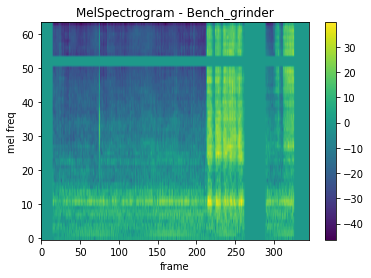

In [23]:
train_transforms = torchvision.transforms.Compose([RandomApply([rand_crop], p=0.7), 
                                                   #noise_reduce, #not working properly, alters sound too much
                                                   #RandomApply([background_noise], p=1), #takes a lot of time
                                                   RandomApply([gaussnoise], p=0.7),
                                                   #custom_spec,
                                                   mel_spectrogram,
                                                   power_to_db,
                                                   #mfcc,
                                                   #normalize,
                                                   RandomApply([time_stretch], p=0.7), #must be before masking
                                                   resize, 
                                                   RandomApply([freq_masking], p=0.7), 
                                                   RandomApply([time_masking], p=0.7),
                                                  ])

val_transforms = torchvision.transforms.Compose([#custom_spec,
                                                 mel_spectrogram, 
                                                 power_to_db,
                                                 #mfcc,
                                                 #normalize,
                                                 #resize
                                                ])

msc_train = MSC_Dataset(ANNOTATIONS_FILE, 
                        AUDIO_DIR, 
                        'train',
                        train_transforms, 
                        SAMPLE_RATE, 
                        NUM_SAMPLES, 
                        device, 
                        label2key_map)

msc_val = MSC_Dataset(ANNOTATIONS_FILE, 
                      AUDIO_DIR, 
                      'val',
                      val_transforms, 
                      SAMPLE_RATE, 
                      NUM_SAMPLES, 
                      device, 
                      label2key_map)

us8k_train = US8k_Dataset('../input/urbansound8k/UrbanSound8K.csv', 
                            '../input/urbansound8k', 
                            'train',
                            train_transforms, 
                            SAMPLE_RATE, 
                            NUM_SAMPLES, 
                            device, 
                            10)

us8k_val = US8k_Dataset('../input/urbansound8k/UrbanSound8K.csv', 
                          '../input/urbansound8k', 
                          'val',
                          val_transforms, 
                          SAMPLE_RATE, 
                          NUM_SAMPLES, 
                          device, 
                          10)

print(f"There are {len(msc_train)} samples in the train dataset.")
print(f"There are {len(msc_val)} samples in the validation dataset.")

signal, label = msc_train[5]

signal_size = signal.shape
print(signal_size)

plot_spectrogram(signal[0], title="MelSpectrogram - "+key2label_map[label.item()], ylabel='mel freq')

#ipd.Audio(signal[0].cpu(), rate=SAMPLE_RATE)

## Dataloader:

In [24]:
#will be freshly called each epoch
train_dataloader = DataLoader(msc_train, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, #data reshuffled at every epoch
                              #sampler=ImbalancedDatasetSampler(msc_train), 
                              num_workers=NUM_WORKERS
                             ) 

val_dataloader = DataLoader(msc_val, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, #not necessary and doesn't matter 
                            num_workers=NUM_WORKERS)

In [25]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels.size())}")

Feature batch shape: torch.Size([32, 1, 64, 345])

Labels batch shape: 1


In [26]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

print(get_mean_and_std(train_dataloader))

(tensor([-1.5571], device='cuda:0'), tensor([11.7333], device='cuda:0'))


## Model:

- #### **Network 13:**

In [72]:
class Network13_12(nn.Module): # without logsoftmax
    def __init__(self, in_channels, num_classes):
        
        super(Network13_12, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.bn0 = nn.LazyBatchNorm2d()
        
        self.conv1 = nn.Sequential(nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.Dropout(0.2)
                                  )
            
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.Dropout(0.2)
                                  )
        
        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.Dropout(0.2)
                                  )
        
        self.conv4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(),
                                   nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.Dropout(0.2)
                                  )
        
        self.fc_final = nn.Linear(512, num_classes)
                                      
        
    def forward(self, x):
        
        x = x.transpose(1, 2)
        x = self.bn0(x)
        x = x.transpose(1,2)        
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)                          
        x = self.conv4(x)
        
        x = F.max_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0:2])
        x = self.fc_final(x)
        return x

## Init:

In [74]:
network = Network13_12(1, num_labels)


cnn = network.to(device)
print(summary(cnn, 
              input_size = train_features.size(), 
              col_names = ("input_size", "output_size", "num_params", "kernel_size")))
try:
    del history
except NameError:
    print('"history" not defined')
    


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape


Network13_12                             [32, 1, 64, 345]          [32, 7]                   --                        --

├─BatchNorm2d: 1-1                       [32, 64, 1, 345]          [32, 64, 1, 345]          128                       --

├─Sequential: 1-2                        [32, 1, 64, 345]          [32, 64, 32, 172]         --                        --

│    └─Conv2d: 2-1                       [32, 1, 64, 345]          [32, 64, 64, 345]         640                       [3, 3]

│    └─BatchNorm2d: 2-2                  [32, 64, 64, 345]         [32, 64, 64, 345]         128                       --

│    └─ReLU: 2-3                         [32, 64, 64, 345]         [32, 64, 64, 345]         --                        --

│    └─Conv2d: 2-4                       [32, 64, 64, 345]         [32, 64, 64, 345]         36,928                    [3, 

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.

  warnings.warn('Lazy modules are a new feature under heavy development '


## Loss Function and Optimizer:

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.SGD(cnn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader), three_phase=False, div_factor=1, final_div_factor = 10)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=1, total_iters=EPOCHS-1)                                            

## Training:

In [76]:
class EarlyStopping:  # github.com/Bjarten/early-stopping-pytorch
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score - self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        network_path = str(type(model).__name__)+'_trained'+now+'_best'+'.pth'
        torch.save(model.state_dict(), network_path)
        self.val_loss_min = val_loss
        
early_stopping = EarlyStopping(patience=50, verbose=True, delta=0)

In [77]:
def evaluate_NEW(model, data_loader, loss_fn):
    '''
    Evaluates model based on the dataloader.
    Returns loss, accuracy and the confusion matrix.    
    '''
    model.eval()
    running_loss = torch.tensor(0.0).to(device)
    running_acc = torch.tensor(0.0).to(device)
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    loss_batch = torch.tensor([]).to(device)

    batch_size = torch.tensor(data_loader.batch_size).to(device)
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            #print('-----New Batch (', step, ') Evaluation------')
            signal = batch[0].to(device)
            target = batch[1].to(device)

            # Predict:
            outputs = model(signal)

            # get batch loss
            loss = loss_fn(outputs, target)
            running_loss = running_loss + loss
            loss_batch = torch.cat((loss_batch, torch.unsqueeze(loss, 0)), dim=0)

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == target).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)

            # safe predictions and targets for confusion matrix
            y_pred = torch.cat((y_pred, predictions), dim=0)
            y_true = torch.cat((y_true, target), dim=0)
   
    loss_epoche = running_loss.item() / (step+1)
    loss_batch = loss_batch.tolist()
    accuracy = running_acc.item() / (step+1)

    return loss_epoche, loss_batch, accuracy, y_pred, y_true

In [78]:
def cf_matrix(y_true, y_pred):
    cf_mat = confusion_matrix(y_true.cpu(), y_pred.cpu())
    numerator = cf_mat.astype('float')
    denominator = cf_mat.sum(axis=1)[:, np.newaxis]
    cf_mat = np.true_divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)   
    return cf_mat
    

In [79]:
def train_single_epoche_NEW(model, data_loader, loss_fn, optimizer, device):
    
    #For evalutation of training:
    running_loss = torch.tensor(0.0).to(device)
    running_acc = torch.tensor(0.0).to(device)
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    loss_batch = torch.tensor([]).to(device)
    batch_size = torch.tensor(data_loader.batch_size).to(device)
    lr = torch.tensor([]).to(device)
    
    with tqdm(total=len(data_loader), file=sys.stdout) as pbar:
        for step, batch in enumerate(data_loader):
            signal = batch[0].to(device)
            target = batch[1].to(device) 

            optimizer.zero_grad() #zero the parameter gradients
            
            cur_lr = torch.tensor(lr_scheduler.get_last_lr()).to(device)
            lr = torch.cat((lr, cur_lr), dim=0) # Document learning rates

            with torch.set_grad_enabled(True): #enable gradient calculation
                prediction = model(signal) #forward
                loss = loss_fn(prediction, target) #calculate loss
                loss.backward() #backpropagate error
                optimizer.step() #update weights
                
                # Evaluate single epoche in training:
                
                # get batch loss
                running_loss = running_loss + loss
                loss_batch = torch.cat((loss_batch, torch.unsqueeze(loss, 0)), dim=0)
                
                # calculate batch accuracy
                predictions = torch.argmax(prediction, dim=1)
                correct_predictions = (predictions == target).float().sum()
                running_acc = running_acc + torch.div(correct_predictions, batch_size)

                # safe predictions and targets for confusion matrix
                y_pred = torch.cat((y_pred, predictions), dim=0)
                y_true = torch.cat((y_true, target), dim=0)
            
            lr_scheduler.step() # Update learning rate
            pbar.update(1)  
            
            
    loss_epoche = running_loss.item() / (step+1)
    loss_batch = loss_batch.tolist()
    accuracy = running_acc.item() / (step+1)
    lr = lr.tolist()

    return loss_epoche, loss_batch, accuracy, y_pred, y_true, lr
                
    
def train_NEW(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs, history=None):
    start_time = datetime.now()
    if history is None:
        history = {'train_loss_epoche':[], 'train_loss_batch':[], 'train_accuracy':[], 'train_confusion_matrix':[], 
                   'val_loss_epoche':[], 'val_loss_batch':[], 'val_accuracy':[], 'val_confusion_matrix':[], 'learning_rate':[]}
    
    # pre-training accuracy
    score = evaluate_NEW(model, val_dataloader, loss_fn)
    print("Pre-training accuracy: %.4f%%" % (100 * score[2]))
    
    for i in range(epochs):
        epoche_start = datetime.now()
        model.train()
        print(f"\nEpoche {i+1}/{epochs}")
        
        # Train and evaluate one eopche
        train_loss_epoche, train_loss_batch, train_acc, train_pred, train_true, lr = train_single_epoche_NEW(model, train_dataloader, loss_fn, optimizer, device)
        print("Training: loss: %.4f - accuracy: %.4f" % (train_loss_epoche, train_acc))
        
        # Document current learning rate
        history['learning_rate'].extend(lr)
        #print('Current learning rate: ', lr)
        
        # Model evaluation - validation data
        val_loss_epoche, val_loss_batch, val_acc, val_pred, val_true = evaluate_NEW(model, val_dataloader, loss_fn)
        print("Validation: val_loss_epoche: %.4f - val_accuracy: %.4f" % (val_loss_epoche, val_acc))  
        
        
        # Store the model's training progress
        history['train_loss_epoche'].append(train_loss_epoche)
        history['train_loss_batch'].extend(train_loss_batch)
        history['train_accuracy'].append(train_acc) 
        
        history['val_loss_epoche'].append(val_loss_epoche)
        history['val_loss_batch'].extend(val_loss_batch)
        history['val_accuracy'].append(val_acc)
        
        epoche_end = datetime.now() - epoche_start
        print(f"Finished epoche in: {epoche_end}")
        print("---------------------------")
        
        # Early stopping
        early_stopping(val_loss_epoche, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    history['train_confusion_matrix'] = cf_matrix(train_pred, train_true)
    history['val_confusion_matrix'] =  cf_matrix(val_pred, val_true)
        
    end_time = datetime.now() - start_time
    print(f"Finished training, duration: {end_time}")
    
    return history

## Train

In [ ]:
now = datetime.now(timezone('Europe/Vienna')).strftime("_%Y-%m-%d_%H-%M")

try:
    prev_history=history
except NameError:
    prev_history=None

history = train_NEW(cnn, train_dataloader, val_dataloader, loss_fn, optimizer, device, EPOCHS, prev_history)
networkname = str(type(cnn).__name__)
network_path = networkname+'_trained'+now+'_last'+'.pth'
torch.save(cnn.state_dict(), network_path)

history_path = networkname+'_trained'+now+'.pickle'
with open(history_path, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Trained CNN saved at " + network_path + ' and history at ' + history_path)

## Load network / results (if not loaded)

In [81]:
folder = '../input/networks/'
load_network = ""

if load_network:
    load_network_path = folder+load_network+'.pth'
    load_cnn = network.to(device)
    state_dict = torch.load(load_network_path)
    cnn.load_state_dict(state_dict)

    with open(folder+load_network+'.pickle', 'rb') as handle:
        history = pickle.load(handle)

## Results:

In [82]:
def show_results(history):
    """Show accuracy and loss graphs for train and test sets."""

    #for i, history in enumerate(tot_history):
        #print('\n({})'.format(i+1))

    plt.figure(figsize=(22,5))

    plt.subplot(1,4,1)
    plt.plot(history['train_accuracy'])
    plt.plot(history['val_accuracy'])
    plt.grid(linestyle='--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoche')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1,4,2)
    plt.plot(history['train_loss_epoche'])
    plt.plot(history['val_loss_epoche'])
    plt.grid(linestyle='--')
    plt.ylabel('Loss')
    plt.xlabel('Epoche')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,4,3)
    plt.plot(history['train_loss_batch'])
    plt.grid(linestyle='--')
    plt.ylabel('Loss')
    plt.xlabel('Batch')
    plt.legend(['train'], loc='upper left')
    
    plt.subplot(1,4,4)
    plt.plot(history['val_loss_batch'], 'darkorange')
    plt.grid(linestyle='--')
    plt.ylabel('Loss')
    plt.xlabel('Batch')
    plt.legend(['validation'], loc='upper left')

    plt.show()
    
    print('\tLast validation accuracy: %.4f %%' % (history['val_accuracy'][-1] * 100))
    print('\tMax validation accuracy: %.4f %%' % (np.max(history['val_accuracy']) * 100))
    print('\tLast validation loss: %.5f' % history['val_loss_epoche'][-1])
    print('\tMin validation loss: %.5f' % np.min(history['val_loss_epoche']))

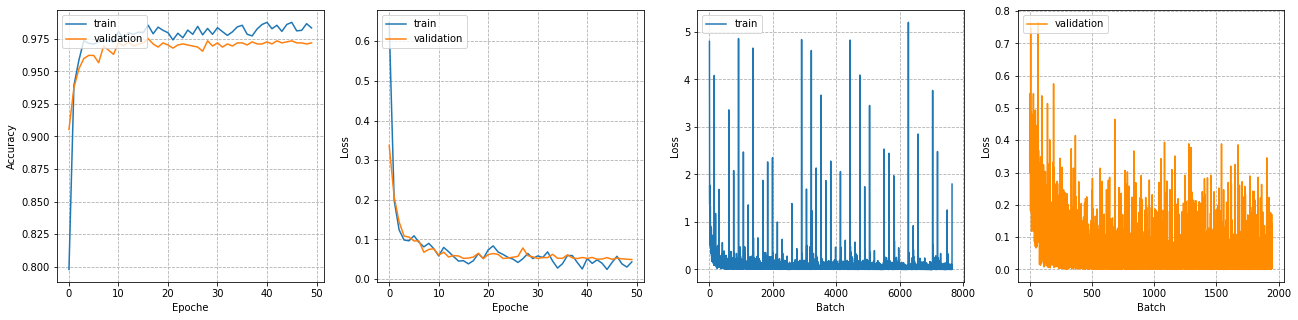

	Last validation accuracy: 97.1955 %

	Max validation accuracy: 97.5160 %

	Last validation loss: 0.04941

	Min validation loss: 0.04941


In [83]:
show_results(history)

In [84]:
def plot_confusion_matrix(matrix, classes, titel):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(matrix, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.xticks(rotation=0) 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(titel)
    fig.autofmt_xdate()
    plt.show(block=False)
    #plt.savefig('output.png')

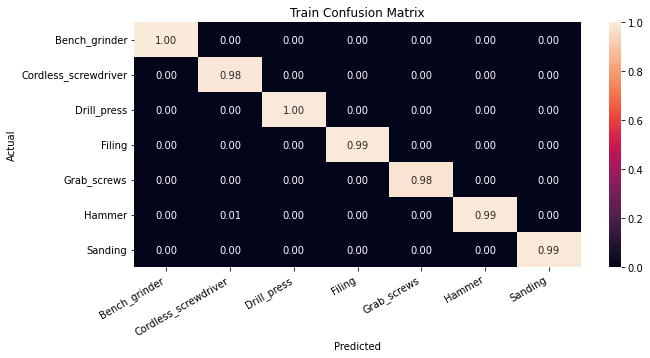

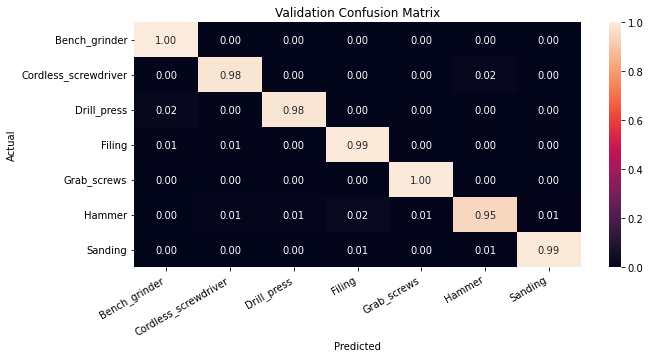

In [85]:
plot_confusion_matrix(history['train_confusion_matrix'], key2label_map.values(), "Train Confusion Matrix")
plot_confusion_matrix(history['val_confusion_matrix'], key2label_map.values(), "Validation Confusion Matrix")

In [86]:
def plot_lr(lr):
    plt.plot(range(len(lr)),lr)
    plt.title("Learning Rate")
    plt.xlabel("Batch")
    plt.ylabel("Learning Rate")
    #xint = range(0, len(lr))
    #plt.xticks(xint)
    plt.show()

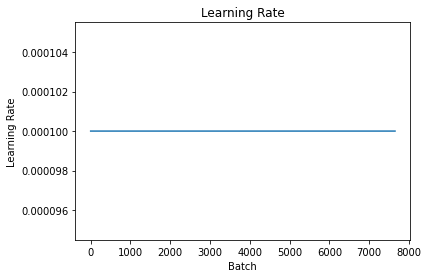

In [87]:
plot_lr(history['learning_rate'])

## Validation:

Validation accuracy: 97.1955 %

Validation loss: 0.04961


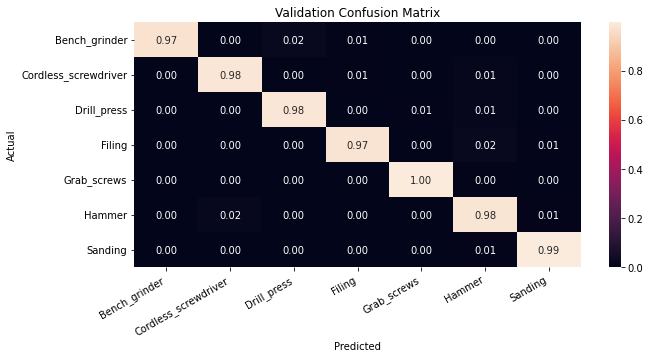

In [88]:
def validation(model, val_dataloader):
    # model evaluation - validation data
    val_loss_epoche, val_loss_batch, val_acc, val_pred, val_true = evaluate_NEW(model, val_dataloader, loss_fn)
    print('Validation accuracy: %.4f %%' % (val_acc * 100))
    print('Validation loss: %.5f' % val_loss_epoche)
    
    val_cfm = cf_matrix(val_true, val_pred)
    plot_confusion_matrix(val_cfm, key2label_map.values(), 'Validation Confusion Matrix')
    
validation(cnn, val_dataloader)

## Single validation:

In [89]:
def single_prediction(model, signal, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(signal)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted = int(predictions[0].argmax(0))
        predicted = class_mapping[predicted]
        expected = class_mapping[target.item()]
    return predicted, expected

In [90]:
# Get single sample:
rand_sample = random.randint(0, len(msc_val)-1)
signal, target = msc_val[rand_sample][0].to(device), msc_val[rand_sample][1]
signal.unsqueeze_(0)

predicted, expected = single_prediction(cnn, signal, target, key2label_map)

print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'Cordless_screwdriver', expected: 'Cordless_screwdriver'
